In [26]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import optax
from jax import random, grad, jit
from functools import partial
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Patch
from IPython.display import HTML

<h1> Linear pendulum system w/ small angle approximation

<h2> ODE </h2>

$$
m\frac{d^2\theta}{dt^2} + \lambda\frac{d\theta}{dt} + \frac{mg}{l}\sin(\theta) = 0
$$

with small-angle approx ($\theta \approx \sin(\theta)$ becomes the linear second-order ODE:

$$
m\frac{d^2\theta}{dt^2} + \lambda\frac{d\theta}{dt} + \frac{mg}{l}\theta = 0
$$

Continuous-time state space model

$$
\begin{bmatrix}
\dot{\theta}\\
\ddot{\theta}
\end{bmatrix}
=
\begin{bmatrix}
0 & 1\\
-\frac{g}{l} & -\frac{\lambda}{m}
\end{bmatrix}
\begin{bmatrix}
\theta\\
\dot{\theta}
\end{bmatrix}, \quad \rightarrow \quad \dot{\mathbf{x}} = A\mathbf{x}
$$
Forward Euler method

$$
\mathbf{x}_k = F \mathbf{x}_{k-1} \quad F = I + A\Delta t
$$

and $\mathbf{x}_0$ as initial conditions. Observation model:

$$
y = C \mathbf{x} =
\begin{bmatrix}
1& 0
\end{bmatrix}
\begin{bmatrix}
\theta\\
\dot{\theta}
\end{bmatrix}
$$

Can include noisy dynamics and observations, and discretize into general state space form using Euler-Maruyama method for discretizing the SDE.

<h2> SDE </h2>

Want to convert the pendulum SDE with random forcing into a general stochastic state space model to allow for filtering. Pendulum SDE with random forcing:

$$
m\frac{d^2\theta}{dt^2} + \lambda\frac{d\theta}{dt} + \frac{mg}{l}\theta = m w
$$

where $w$ is a white-noise process with spectral density $q$. Considering the SDE below can be discretized using the Euler-Maruyama scheme:

$$
d\mathbf{x} = A\mathbf{x}dt + L d\beta
$$

$$
\mathbf{x}_k \approx \mathbf{x}_{k-1} + A \mathbf{x}_{k-1} \Delta t + L\Delta \beta_k, \quad \Delta \beta_k \sim \mathcal{N}(0,q\Delta t)
$$

$$
p(\mathbf{x}_k | \mathbf{x}_{k-1}) = \mathcal{N}( (I + A\Delta t) \mathbf{x}_{k-1}, q\Delta t LL^T )
$$

for the pendulum model with stochastic forcing, we have the following continuous-time model

$$
\begin{bmatrix}
\dot{\theta}\\
\ddot{\theta}
\end{bmatrix}
=
\begin{bmatrix}
0 & 1\\
-\frac{g}{l} & -\frac{\lambda}{m}
\end{bmatrix}
\begin{bmatrix}
\theta\\
\dot{\theta}
\end{bmatrix}
+
\begin{bmatrix}
0\\
1
\end{bmatrix}
w
$$

when discretizing with E-M

$$
\mathbf{x}_k = F \mathbf{x}_{k-1} + L w_k , \quad F = I + A\Delta t, \quad w_k \sim \mathcal{N}(0,q\Delta t)
$$

Can now generate data with process noise and observation noise.

<h2> Linear Gaussian SSM </h2>
    
$$
\mathbf{x}_k = F \mathbf{x}_{k-1} + \mathbf{w}_k, \quad \mathbf{w}_k \sim \mathcal{N}(0,Q)
$$

$$
\mathbf{y}_k = C x_{k} + \mathbf{v}_k, \quad \mathbf{v}_k \sim \mathcal{N}(0,R)
$$

<h2> Euler-Maruyama process covariance </h2>

$$
Q_{\text{EM}} =
\begin{bmatrix}
0 & 0\\
0 & q\Delta t
\end{bmatrix}
$$


*generate data from an initial condition $\mathbf{x}_0 = [\pi/4, 0]$ and sampling process and obsercation noise to give a sequence $\{y_n\}_{n=1}^N$.

*apply the Kalman filter to estimate both the angle and angular velocity, give this sequence of observations. Visualise the mean and variance of these states through time, plotted alongside the data. For stability

In [27]:
initial_angle = 45                # degrees
t0 = initial_angle * (jnp.pi / 180)  # theta_0 in rad
td0 = 0                           # theta_dot_0

# Model parameters
g = 9.81
l = 0.5
m = 1
lam = 0.6  # lambda

# Time parameters
T = 10
dt = 0.01
N = int(T / dt)  # Ensure N is an integer

# Stochastic parameters
sigma = 0.35    # observation noise standard deviation
q = 0.01         # process noise variance
R = sigma ** 2

A_friction = jnp.array([[0, 1], [-g / l, -lam / m]])

I = jnp.eye(2)
F = I + A_friction * dt

Q = q * dt * jnp.array([[0., 0.], [0., 1.]])
C = jnp.array([1., 0.])
x0 = jnp.array([t0, td0])

key = random.PRNGKey(0)
key, subkey = random.split(key)
delta_beta = random.normal(subkey, shape=(N,)) * jnp.sqrt(q * dt)


w = jnp.stack([jnp.zeros(N), delta_beta], axis=1)

key, subkey = random.split(key)
v = random.normal(subkey, shape=(N + 1,)) * sigma


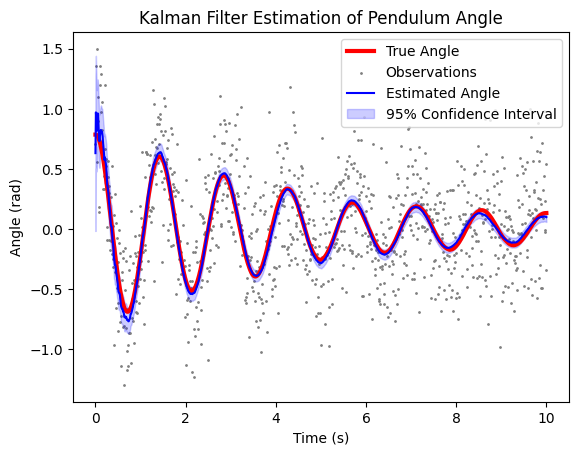

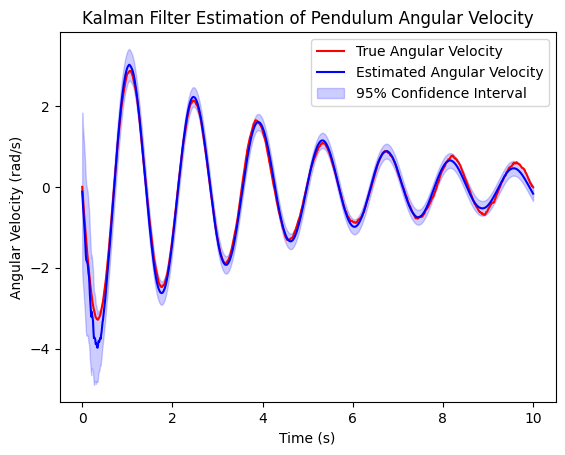

In [28]:
"""Resources used
https://engineeringmedia.com/controlblog/the-kalman-filter
https://en.wikipedia.org/wiki/Kalman_filter"""
y0 = C @ x0 + v[0]

def step(x_prev, inputs):
    w_k, v_k = inputs
    x_k = F @ x_prev + w_k
    y_k = C @ x_k + v_k
    return x_k, (x_k, y_k)

inputs = (w, v[1:])

x_last, (x_states, y_obs) = jax.lax.scan(step, x0, inputs)

x_full = jnp.vstack([x0, x_states])
y_full = jnp.concatenate([jnp.array([y0]), y_obs])

"""Kalman Filter"""

x_est_0 = jnp.array([0., 0.])
P0 = jnp.array([[1., 0.], [0., 1.]])


def kalman_step(carry, y_k):
    x_est_prev, P_prev = carry

    x_pred = F @ x_est_prev
    P_pred = F @ P_prev @ F.T + Q

    y_pred = C @ x_pred
    e = y_k - y_pred
    S = C @ P_pred @ C.T + R
    K = P_pred @ C.T / S
    x_est = x_pred + K * e
    P_est = (jnp.eye(2) - K[:, None] * C[None, :]) @ P_pred
    return (x_est, P_est), (x_est, P_est)

inputs = y_full

carry = (x_est_0, P0)

carry, outputs = jax.lax.scan(kalman_step, carry, inputs)

x_estimates = jnp.vstack([x_est_0, outputs[0]])
P_estimates = jnp.stack([P0] + [P for P in outputs[1]])


time = jnp.linspace(0, T, N+1)


theta_est = x_estimates[:, 0]
theta_dot_est = x_estimates[:, 1]

theta_true = x_full[:, 0]
theta_dot_true = x_full[:, 1]

theta_std = jnp.sqrt(P_estimates[:, 0, 0])
theta_upper = theta_est + 1.96 * theta_std
theta_lower = theta_est - 1.96 * theta_std


theta_dot_std = jnp.sqrt(P_estimates[:, 1, 1])
theta_dot_upper = theta_dot_est + 1.96 * theta_dot_std
theta_dot_lower = theta_dot_est - 1.96 * theta_dot_std


plt.plot(time, theta_true, label='True Angle', color='red', linewidth=3)
plt.scatter(time, y_full, s=1, label='Observations', color='grey')
plt.plot(time, theta_est[1:], label='Estimated Angle', color='blue')
plt.fill_between(time, theta_lower[1:], theta_upper[1:], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Kalman Filter Estimation of Pendulum Angle')
plt.show()


plt.plot(time, theta_dot_true, label='True Angular Velocity', color='red')
plt.plot(time, theta_dot_est[1:], label='Estimated Angular Velocity', color='blue')
plt.fill_between(time, theta_dot_lower[1:], theta_dot_upper[1:], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.title('Kalman Filter Estimation of Pendulum Angular Velocity')
plt.show()

lambda: 1.4233 (true: 0.6)
m: 2.1011 (true: 1)
l: 0.5044 (true: 0.5)


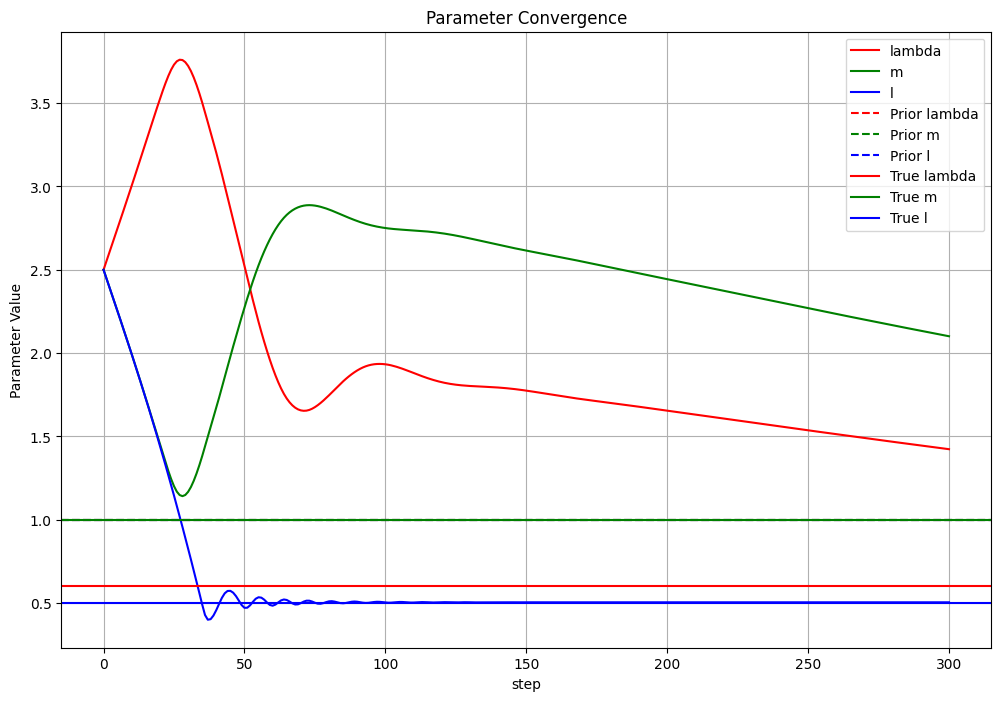

In [29]:
mu_lambda = 1
sigma_lambda = 1
mu_m = 1
sigma_m = 1
mu_l = 1
sigma_l = 1

priors = (mu_lambda, sigma_lambda, mu_m, sigma_m, mu_l, sigma_l)

def compute_F(m, l, lam):
    A_friction = jnp.array([[0, 1], [-g / l, -lam / m]])
    return I + A_friction * dt

@jit
def kalman_filter(y, F, Q, C, R, x0, P0):
    def step_fn(carry, y_k):
        x_est_prev, P_prev = carry
        # Prediction
        x_pred = F @ x_est_prev
        P_pred = F @ P_prev @ F.T + Q

        # Update
        y_pred = C @ x_pred
        e = y_k - y_pred
        S = C @ P_pred @ C.T + R
        K = (P_pred @ C) / S
        x_est = x_pred + K * e
        P_est = (jnp.eye(2) - K[:, None] * C[None, :]) @ P_pred

        return (x_est, P_est), (S, y_pred)

    carry = (x0, P0)
    (_, _), (S, y_pred) = jax.lax.scan(step_fn, carry, y)
    return S, y_pred

def log_posterior(params, y_obs, priors):
    lam, m, l = params
    mu_lambda, sigma_lambda, mu_m, sigma_m, mu_l, sigma_l = priors

    F = compute_F(m, l, lam)
    Q = q * dt * jnp.array([[0., 0.], [0., 1.]])

    x_est_0 = jnp.array([t0, td0])
    P0 = jnp.array([[1., 0.], [0., 1.]])
    S, y_pred = kalman_filter(y_obs, F, Q, C, R, x_est_0, P0)

    log_likelihood = -0.5 * jnp.sum(jnp.log(2 * jnp.pi * S) + ((y_obs - y_pred.flatten())**2) / S)

    log_prior_lambda = -0.5 * ((lam - mu_lambda)**2) / (sigma_lambda**2) - jnp.log(jnp.sqrt(2 * jnp.pi) * sigma_lambda)
    log_prior_m = -0.5 * ((m - mu_m)**2) / (sigma_m**2) - jnp.log(jnp.sqrt(2 * jnp.pi) * sigma_m)
    log_prior_l = -0.5 * ((l - mu_l)**2) / (sigma_l**2) - jnp.log(jnp.sqrt(2 * jnp.pi) * sigma_l)

    log_posterior = log_likelihood + log_prior_lambda + log_prior_m + log_prior_l
    return log_posterior

@jit
def loss_fn(params, y_obs, priors):
    return -log_posterior(params, y_obs, priors)

def parameter_inference(y_full, priors, initial_params, learning_rate=1e-2, num_iterations=1000):
    params = initial_params
    optimiser = optax.adam(learning_rate=learning_rate)
    opt_state = optimiser.init(params)

    @jit
    def update(params, opt_state, y_obs, priors):
        loss, grads = jax.value_and_grad(loss_fn)(params, y_obs, priors)
        updates, opt_state = optimiser.update(grads, opt_state)
        params = optax.apply_updates(params, updates)

        params = jnp.maximum(params, 0.01)
        return params, opt_state, loss

    param_history = [params]
    loss_history = []

    for i in range(num_iterations):
        params, opt_state, loss = update(params, opt_state, y_full, priors)
        param_history.append(params)
        loss_history.append(loss)
        #print(f"Iteration {i+1}, Loss: {loss:.4f}, Parameters: {params}")

    param_history = jnp.stack(param_history)
    loss_history = jnp.array(loss_history)

    return params, param_history, loss_history

def plot_convergence(param_history, priors, true_params=None):
    mu_lambda, _, mu_m, _, mu_l, _ = priors
    plt.figure(figsize=(12, 8))
    plt.plot(param_history[:, 0], color='r', label='lambda')
    plt.plot(param_history[:, 1], color='g', label='m')
    plt.plot(param_history[:, 2], color='b', label='l')

    plt.axhline(y=mu_lambda, color='r', linestyle='--', label='Prior lambda')
    plt.axhline(y=mu_m, color='g', linestyle='--', label='Prior m')
    plt.axhline(y=mu_l, color='b', linestyle='--', label='Prior l')

    if true_params is not None:
        plt.axhline(y=true_params[0], color='r', linestyle='-', label='True lambda')
        plt.axhline(y=true_params[1], color='g', linestyle='-', label='True m')
        plt.axhline(y=true_params[2], color='b', linestyle='-', label='True l')

    plt.xlabel('step')
    plt.ylabel('Parameter Value')
    plt.title('Parameter Convergence')
    plt.legend()
    plt.grid(True)
    plt.show()


initial_params = jnp.array([2.5, 2.5, 2.5])

estimated_params, param_history, loss_history = parameter_inference(
    y_full=y_full,
    priors=priors,
    initial_params=initial_params,
    learning_rate=5e-2,
    num_iterations=300
)

print(f"lambda: {estimated_params[0]:.4f} (true: {lam})")
print(f"m: {estimated_params[1]:.4f} (true: {m})")
print(f"l: {estimated_params[2]:.4f} (true: {l})")


plot_convergence(
    param_history=param_history,
    priors=priors,
    true_params=[lam, m, l]
)



m: 0.8880 (true: 1)


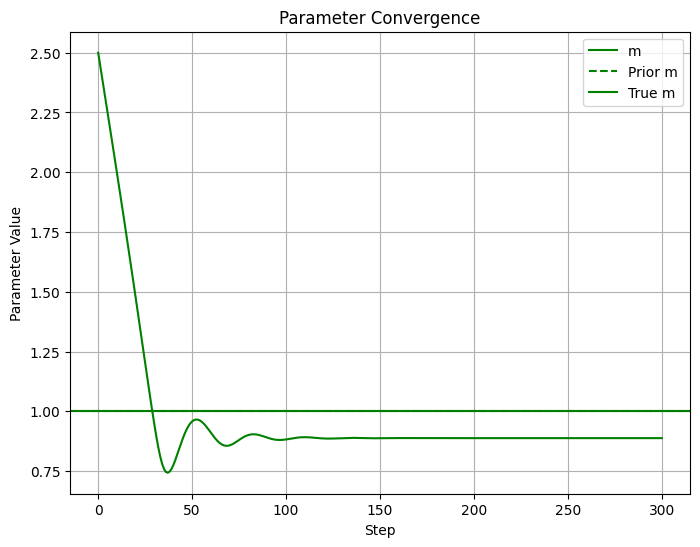

In [30]:
true_lambda = 0.6
true_l = 0.5

mu_m = 1
sigma_m = 1
priors = (mu_m, sigma_m)

def compute_F(m, l=true_l, lam=true_lambda):
    A_friction = jnp.array([[0, 1], [-g / l, -lam / m]])
    return I + A_friction * dt

@jit
def kalman_filter(y, F, Q, C, R, x0, P0):
    def step_fn(carry, y_k):
        x_est_prev, P_prev = carry
        # Prediction
        x_pred = F @ x_est_prev
        P_pred = F @ P_prev @ F.T + Q

        # Update
        y_pred = C @ x_pred
        e = y_k - y_pred
        S = C @ P_pred @ C.T + R
        K = (P_pred @ C) / S
        x_est = x_pred + K * e
        P_est = (jnp.eye(2) - K[:, None] * C[None, :]) @ P_pred

        return (x_est, P_est), (S, y_pred)

    carry = (x0, P0)
    (_, _), (S, y_pred) = jax.lax.scan(step_fn, carry, y)
    return S, y_pred

def log_posterior(m, y_obs, priors):
    mu_m, sigma_m = priors
    F = compute_F(m)
    Q = q * dt * jnp.array([[0., 0.], [0., 1.]])

    x_est_0 = jnp.array([t0, td0])
    P0 = jnp.array([[1., 0.], [0., 1.]])
    S, y_pred = kalman_filter(y_obs, F, Q, C, R, x_est_0, P0)

    log_likelihood = -0.5 * jnp.sum(jnp.log(2 * jnp.pi * S) + ((y_obs - y_pred.flatten())**2) / S)
    log_prior_m = -0.5 * ((m - mu_m)**2) / (sigma_m**2) - jnp.log(jnp.sqrt(2 * jnp.pi) * sigma_m)

    log_posterior = log_likelihood + log_prior_m
    return log_posterior

@jit
def loss_fn(m, y_obs, priors):
    return -log_posterior(m, y_obs, priors)

def parameter_inference(y_full, priors, initial_m, learning_rate=1e-2, num_iterations=1000):
    m = initial_m
    optimiser = optax.adam(learning_rate=learning_rate)
    opt_state = optimiser.init(m)

    @jit
    def update(m, opt_state, y_obs, priors):
        loss, grads = jax.value_and_grad(loss_fn)(m, y_obs, priors)
        updates, opt_state = optimiser.update(grads, opt_state)
        m = optax.apply_updates(m, updates)
        return m, opt_state, loss

    m_history = [m]
    loss_history = []

    for i in range(num_iterations):
        m, opt_state, loss = update(m, opt_state, y_full, priors)
        m_history.append(m)
        loss_history.append(loss)

    m_history = jnp.stack(m_history)
    loss_history = jnp.array(loss_history)

    return m, m_history, loss_history

def plot_convergence(m_history, priors, true_m=None):
    mu_m, _ = priors
    plt.figure(figsize=(8, 6))
    plt.plot(m_history, color='g', label='m')

    plt.axhline(y=mu_m, color='g', linestyle='--', label='Prior m')

    if true_m is not None:
        plt.axhline(y=true_m, color='g', linestyle='-', label='True m')

    plt.xlabel('Step')
    plt.ylabel('Parameter Value')
    plt.title('Parameter Convergence')
    plt.legend()
    plt.grid(True)
    plt.show()

initial_m = jnp.array(2.5)

estimated_m, m_history, loss_history = parameter_inference(
    y_full=y_full,
    priors=priors,
    initial_m=initial_m,
    learning_rate=5e-2,
    num_iterations=300
)

print(f"m: {estimated_m:.4f} (true: {m})")

plot_convergence(
    m_history=m_history,
    priors=priors,
    true_m=m
)


In [31]:
"""https://siliconwit.com/modelling-and-simulation-in-python/simulating-a-swinging-pendulum
resource which aided creation of simulation"""

x_true = l * jnp.sin(theta_true)
y_true = -l * jnp.cos(theta_true)

x_est = l * jnp.sin(theta_est)
y_est = -l * jnp.cos(theta_est)

theta_upper = theta_est + 1.96 * theta_std
theta_lower = theta_est - 1.96 * theta_std

x_upper = l * jnp.sin(theta_upper)
y_upper = -l * jnp.cos(theta_upper)

x_lower = l * jnp.sin(theta_lower)
y_lower = -l * jnp.cos(theta_lower)

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-l - 0.1, l + 0.1)
ax.set_ylim(-l - 0.1, l + 0.1)
ax.grid(False)

line_true, = ax.plot([], [], 'o-', lw=2, color='green', label='True Pendulum')
line_est, = ax.plot([], [], 'o-', lw=2, color='blue', label='Estimated Pendulum')

time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

confidence_patch = None
confidence_proxy = Patch(facecolor='blue', edgecolor='blue', alpha=0.1, label='95% Confidence Interval')

ax.legend(handles=[line_true, line_est, confidence_proxy], loc='upper right')

# Sampling
n = 10
frames = range(0, len(time), n)

def init():
    global confidence_patch
    line_true.set_data([], [])
    line_est.set_data([], [])
    if confidence_patch is not None:
        confidence_patch.remove()
        confidence_patch = None
    time_text.set_text('')
    return line_true, line_est, time_text

def animate(i):
    global confidence_patch
    idx = frames[i]
    line_true.set_data([0, x_true[idx]], [0, y_true[idx]])
    line_est.set_data([0, x_est[idx]], [0, y_est[idx]])

    if confidence_patch is not None:
        confidence_patch.remove()

    x_confidence = [0, x_upper[idx], x_lower[idx]]
    y_confidence = [0, y_upper[idx], y_lower[idx]]
    confidence_patch = ax.fill(x_confidence, y_confidence, color='blue', alpha=0.1)[0]

    time_text.set_text(f'Time = {time[idx]:.2f} s')
    return line_true, line_est, confidence_patch, time_text

ani = FuncAnimation(fig, animate, frames=len(frames), interval=dt*1000*n, blit=True, init_func=init)
plt.close(fig)
HTML(ani.to_jshtml())




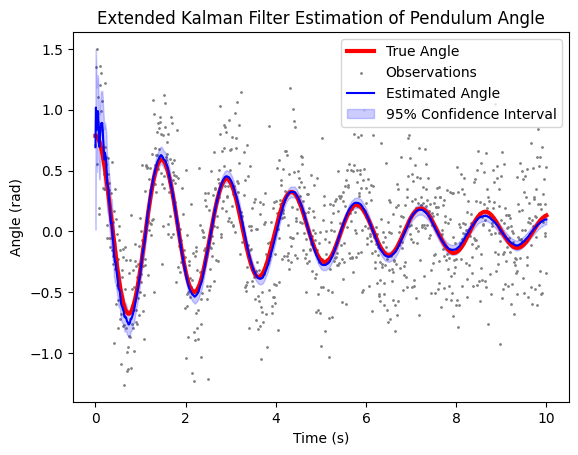

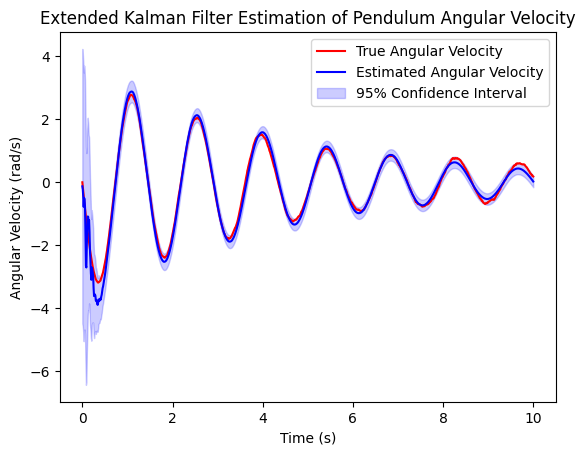

In [32]:
"""https://en.wikipedia.org/wiki/Extended_Kalman_filter"""
def f(x):
    theta, omega = x
    theta_new = theta + omega * dt
    omega_new = omega + (- (g / l) * jnp.sin(theta) - (lam / m) * omega) * dt
    return jnp.array([theta_new, omega_new])

def c(x):
    theta, omega = x
    return theta

def step(x_prev, inputs):
    w_k, v_k = inputs
    x_k = f(x_prev) + w_k
    y_k = h(x_k) + v_k
    return x_k, (x_k, y_k)

inputs = (w, v[1:])

x_last, (x_states, y_obs) = jax.lax.scan(step, x0, inputs)

x_full = jnp.vstack([x0, x_states])
y_full = jnp.concatenate([jnp.array([h(x0) + v[0]]), y_obs])

"""extended kalman filter"""

x_est_0 = jnp.array([0., 0.])
P0 = jnp.array([[5., 0.], [0., 5.]])

Q = q * dt * jnp.array([[0., 0.], [0., 1.]])

#Jacobians
def compute_F(x):
    theta, omega = x
    F = jnp.array([
        [1, dt],
        [-(g / l) * jnp.cos(theta) * dt, 1 - (lam / m) * dt]
    ])
    return F

def compute_C(x):
    C = jnp.array([1., 0.])
    return C

def ekf_step(carry, y_k):
    x_est_prev, P_prev = carry

    F_k = compute_F(x_est_prev)
    x_pred = f(x_est_prev)
    P_pred = F_k @ P_prev @ F_k.T + Q

    C_k = compute_C(x_pred)
    y_pred = c(x_pred)
    e = y_k - y_pred
    S = C_k @ P_pred @ C_k.T + R
    K = P_pred @ C_k.T / S
    x_est = x_pred + K * e
    P_est = (jnp.eye(2) - K[:, None] * C_k[None, :]) @ P_pred
    return (x_est, P_est), (x_est, P_est)

inputs = y_full

carry = (x_est_0, P0)
carry, outputs = jax.lax.scan(ekf_step, carry, inputs)

x_estimates = jnp.vstack([x_est_0, outputs[0]])
P_estimates = jnp.stack([P0] + [P for P in outputs[1]])

time = jnp.linspace(0, T, N + 1)

theta_est = x_estimates[:, 0]
theta_dot_est = x_estimates[:, 1]

theta_true = x_full[:, 0]
theta_dot_true = x_full[:, 1]

theta_std = jnp.sqrt(P_estimates[:, 0, 0])
theta_upper = theta_est + 1.96 * theta_std
theta_lower = theta_est - 1.96 * theta_std

theta_dot_std = jnp.sqrt(P_estimates[:, 1, 1])
theta_dot_upper = theta_dot_est + 1.96 * theta_dot_std
theta_dot_lower = theta_dot_est - 1.96 * theta_dot_std

plt.plot(time, theta_true, label='True Angle', color='red', linewidth=3)
plt.scatter(time, y_full, s=1, label='Observations', color='grey')
plt.plot(time, theta_est[1:], label='Estimated Angle', color='blue')
plt.fill_between(time, theta_lower[1:], theta_upper[1:], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Extended Kalman Filter Estimation of Pendulum Angle')
plt.show()

plt.plot(time, theta_dot_true, label='True Angular Velocity', color='red')
plt.plot(time, theta_dot_est[1:], label='Estimated Angular Velocity', color='blue')
plt.fill_between(time, theta_dot_lower[1:], theta_dot_upper[1:], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.title('Extended Kalman Filter Estimation of Pendulum Angular Velocity')
plt.show()


In [33]:
"""https://siliconwit.com/modelling-and-simulation-in-python/simulating-a-swinging-pendulum
resource which aided creation of simulation"""

x_true = l * jnp.sin(theta_true)
y_true = -l * jnp.cos(theta_true)

x_est = l * jnp.sin(theta_est)
y_est = -l * jnp.cos(theta_est)

theta_upper = theta_est + 1.96 * theta_std
theta_lower = theta_est - 1.96 * theta_std

x_upper = l * jnp.sin(theta_upper)
y_upper = -l * jnp.cos(theta_upper)

x_lower = l * jnp.sin(theta_lower)
y_lower = -l * jnp.cos(theta_lower)

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-l - 0.1, l + 0.1)
ax.set_ylim(-l - 0.1, l + 0.1)
ax.grid(False)

line_true, = ax.plot([], [], 'o-', lw=2, color='green', label='True Pendulum')
line_est, = ax.plot([], [], 'o-', lw=2, color='blue', label='Estimated Pendulum')

time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

confidence_patch = None
confidence_proxy = Patch(facecolor='blue', edgecolor='blue', alpha=0.1, label='95% Confidence Interval')

ax.legend(handles=[line_true, line_est, confidence_proxy], loc='upper right')

# Sampling
n = 10
frames = range(0, len(time), n)

def init():
    global confidence_patch
    line_true.set_data([], [])
    line_est.set_data([], [])
    if confidence_patch is not None:
        confidence_patch.remove()
        confidence_patch = None
    time_text.set_text('')
    return line_true, line_est, time_text

def animate(i):
    global confidence_patch
    idx = frames[i]
    line_true.set_data([0, x_true[idx]], [0, y_true[idx]])
    line_est.set_data([0, x_est[idx]], [0, y_est[idx]])

    if confidence_patch is not None:
        confidence_patch.remove()

    x_confidence = [0, x_upper[idx], x_lower[idx]]
    y_confidence = [0, y_upper[idx], y_lower[idx]]
    confidence_patch = ax.fill(x_confidence, y_confidence, color='blue', alpha=0.1)[0]

    time_text.set_text(f'Time = {time[idx]:.2f} s')
    return line_true, line_est, confidence_patch, time_text

ani = FuncAnimation(fig, animate, frames=len(frames), interval=dt*1000*n, blit=True, init_func=init)
plt.close(fig)
HTML(ani.to_jshtml())


